<center>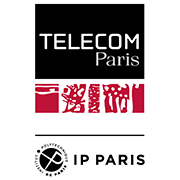</center>

<h1><center><strong><font color="green">IA 717: Linguistic Differences of Human-Human and AI-Generated Conversations</font></strong></center></h1>
<h3><center><font color="blue"><strong>Student Version</strong></font></center></h3>

<center>
<h3> Project Supervisor <br/> <a>Yi YU</a></h3>
<email>yi.yu@inria.fr</email>
<br/>

Year 2025-2026
</center>

------------------------

# <font color="green">**Context & Objectives**</font>

> The application of large language models (LLMs) in dialogue-based scenarios has become part of daily life since 2023. Human-LLM corpora are now available and enable the study on differences between Human-Human conversations and those generated by LLMs. The differences between these conversations can provide insights into potential alignment direction for current LLM-based chatbot with human expectations.

The objective of this project is to study the linguistic difference between two chosen corpora, <a href="https://github.com/facebookresearch/EmpatheticDialogues">EmpathicDialogues</a> and <a href="https://github.com/morganlee123/2GPTEmpathicDialogues">2GPTEmpathicDialogues</a>. The second is created as a replica of the first one by prompting two independent instances of ChatGPT. 

The following image provides an example of two conversations genereated under the same scenario, one by human, the other by ChatGPT.
![image.png](https://github.com/morganlee123/2GPTEmpathicDialogues/blob/main/paperfigures/exampledialogue.png?raw=true) 

We will first start with an exploration of basic concepts for conversation analysis (e.g. nb of turns per conversation, avg words per turn, etc.) and understand what has been studied within these two corpora in <a href="https://arxiv.org/abs/2401.16587">this paper</a>. We will then compare these two corpora on our own, focusing on one linguistic feature for affect study introduced later and calculate it for each conversation.

1) explore the mentioned corpora
2) analyze the general information about each corpus: the size of corpus and the setting used for the corpus creation 
3) study one linguistic feature for collaborative state analysis, <a href="https://www.liwc.app/help/lsm">language style matching</a>, calculate it for each pair of participants, human or ChatGPT, and finally compare the level of matching between two corpora
4) build a baseline model for LLM-generated dialogue detection using only word embedding as feature
5) add the calculated feature from step <a>3</a> to your baseline model to see if there is any improvement in performance
6) highlight your findings during the experiment


### <font color="green">Evaluation</font>

The project is evaluated through a presentation with a report and your completed project. Grades will be partly individual and partly collective. 

# <font color="green">**1 & 2 - Data Retrieval & Analysis**</font>

We need to download the two mentioned corpora using the link provided earlier. Each conversation in EmpatheticDialogue should be paired with a conversation in 2GPTEmpathicDialogues. Check if any conversation cannot be paired

<font color="red"> 1.1 Question: </font>  
Preprocessing and Data Exploration — Answer the following:

- How many conversations in EmpatheticDialogue can be paired with those in 2GPTEmpathicDialogues?  
- What is the average number of turns per conversation in each corpus?  
- What is the average number of words per conversation in both corpora?  
- How are conversations distributed across different emotional contexts (e.g., annoyed, proud, furious)?  

Present your findings using appropriate graphs and visualizations where possible.

<font color="orange">1.1 Answer:</font> 

In [17]:
# imports
import pandas as pd
import numpy as np

In [18]:
# Read data

gpt_byconv = pd.read_csv("../data/2GPTEmpathicDialoguesDataset.csv", usecols=[1,2,3,4,5], index_col="conv_id")

# On ignore les dernières colonnes à l'import de human_valid et human_test (non utiles pour le projet + erreurs de parsing)
# On ignore les double-quotes pour human pour prendre en compte tous les séparateurs
dial_human = pd.read_csv("../data/empatheticdialogues/train.csv", quoting=3, usecols=[0,1,2,3,4,5], index_col=["conv_id", "utterance_idx"])
dial_human_valid = pd.read_csv("../data/empatheticdialogues/valid.csv", quoting=3, usecols=[0,1,2,3,4,5], index_col=["conv_id", "utterance_idx"])
dial_human_test = pd.read_csv("../data/empatheticdialogues/test.csv", quoting=3, usecols=[0,1,2,3,4,5], index_col=["conv_id", "utterance_idx"])

# Empilement des tables test, valid et train pour s'assurer d'avoir le maximum de données communes
human_byutt = pd.concat([dial_human, dial_human_valid, dial_human_test])

In [ ]:
human_byutt["utterance"] = human_byutt["utterance"].str.replace("_comma_", ",", regex=False)

# Regroupement des utterances par conversation pour la table human
human_byconv = human_byutt.groupby("conv_id").agg({"context": "first", 
                                                   "prompt": "first", 
                                                   "speaker_idx": "nunique",
                                                   "utterance": lambda x: " ".join(x)})

# Division des conversations par utterance pour la table gpt

gpt_byutt = (gpt_byconv
             .assign(utterance=gpt_byconv["processed"].str.split("\n"))
             .explode("utterance")
             .query("utterance != ''")
             )
gpt_byutt['utterance_idx'] = gpt_byutt.groupby('conv_id').cumcount() + 1
gpt_byutt['speaker_idx'] = gpt_byutt['utterance_idx'] % 2

# Pour limiter les imperfections du prompting, on force le maximum d'utterances à 6 par conversation
gpt_byutt = gpt_byutt[gpt_byutt["utterance_idx"] < 7]
gpt_byconv = gpt_byutt.groupby("conv_id").agg({"context": "first",
                                               "prompt": "first",
                                               "utterance": lambda x: " ".join(x)})

gpt_byutt = gpt_byutt.set_index(["utterance_idx"], append=True)


In [20]:
# Suppression des conv_id avec un seul speaker
gpt_byconv = gpt_byconv[gpt_byutt.groupby("conv_id")["speaker_idx"].nunique() == 2]
human_byconv = human_byconv[human_byutt.groupby("conv_id")["speaker_idx"].nunique() == 2]

# On ne garde que les communs
gpt_byconv = gpt_byconv[gpt_byconv.index.isin(human_byconv.index)]
gpt_byutt = gpt_byutt[gpt_byutt.index.get_level_values("conv_id").isin(human_byconv.index)]
human_byconv = human_byconv[human_byconv.index.isin(gpt_byconv.index)]
human_byutt = human_byutt[human_byutt.index.get_level_values("conv_id").isin(gpt_byconv.index)]


# On renomme les variables
gpt_byconv = gpt_byconv.rename(columns={"utterance": "conversation"})
human_byconv = human_byconv.rename(columns={"utterance": "conversation"})



Les data ne sont pas sur le même format :
- chaque observation pour dial_gpt correspond à un dialogue
- chaque observation pour dial_human correspond à une prise de parole

> On cherche donc à transformer la table "dial_gpt" de manière à pouvoir faire une jointure avec la table "dial_human"
> 
> - On suppose que la clé de conv_id permettra de faire la jointure
> - Mais il faut au préalable éclater la colonne "processed" 

In [21]:
print("Nombre de conversations communes aux deux bases : ", len(gpt_byconv))
print("Nombre moyen d'utterances par conversation : \n", 
      "GPT : ", gpt_byutt.groupby('conv_id').count()['utterance'].mean(), 
      "\nHuman : ", human_byutt.groupby('conv_id').count()['utterance'].mean())
print("average number of words per conversation : \n", 
      "GPT :", np.mean(gpt_byconv["conversation"].str.split().str.len()),
      "\nHuman :", np.mean(human_byconv["conversation"].str.split().str.len())
      )
print("average number of words per utterance : \n", 
      "GPT :", np.mean(gpt_byutt["utterance"].str.split().str.len()),
      "\nHuman :", np.mean(human_byutt["utterance"].str.split().str.len())
      )


Nombre de conversations communes aux deux bases :  19531
Nombre moyen d'utterances par conversation : 
 GPT :  5.267574624955199 
Human :  4.309405560391173
average number of words per conversation : 
 GPT : 188.79084532282013 
Human : 57.72192924069428
average number of words per utterance : 
 GPT : 35.840184290588155 
Human : 13.394406358786698


<Axes: xlabel='context'>

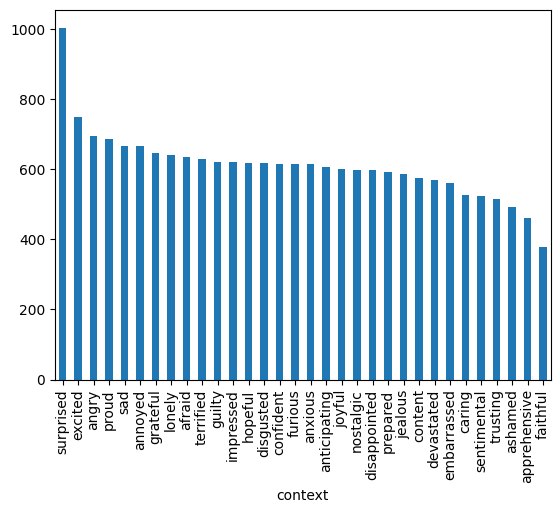

In [6]:
# Distribution of contexts 
human_byconv["context"].value_counts().plot.bar()

<font color="red">1.2 Question:</font> Summarize your findings during the preprocessing process. Do you think we should include all the available contexts for our study? Why? 'Context' here refer to a column name in EmpatheticDialogue csv file.

<font color="orange">1.2 Answer:</font> 

In [7]:
# To-do


<font color="red">2.1 Question:</font> Understand the prompting design used in 2GPTEmpathicDialogue generation. What are the advantages and limitations of this setting?

<font color="orange">2.1 Answer:</font> 

In [8]:
# To-do

# <font color="green">**3 - Linguistic Feature for the Affective State between Participants**</font>

LSM is a linguistic feature related to affect analysis. You can add more as you like. You need to make sure each of your choice is supported by at least one published paper since the references are required. You need to check how to calculate each of the feature using dialogue text.

<font color="red">3.0 Question:</font> What is the affect analysis? What are possible scenario/application for affect analysis?

<font color="orange">3.0 Answer:</font> 

In [24]:
import spacy
from collections import defaultdict
import os
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])

n_cpus = os.cpu_count()
print(f"Using {n_cpus} CPU cores")

human_grouped = (
    human_byutt
    .groupby(["conv_id", "speaker_idx"])["utterance"]
    .apply(lambda x: " ".join(x))    # concatène toutes les utterances d'un même locuteur
    .reset_index()
)


gpt_grouped = (
    gpt_byutt
    .groupby(["conv_id", "speaker_idx"])["utterance"]
    .apply(lambda x: " ".join(x))    # concatène toutes les utterances d'un même locuteur
    .reset_index()
)

human_docs = list(
    nlp.pipe(human_grouped["utterance"], batch_size=200, n_process=n_cpus)
)
gpt_docs = list(
    nlp.pipe(gpt_grouped["utterance"], batch_size=200, n_process=n_cpus)
)


Using 10 CPU cores


In [25]:
# Defining the pos tagging dictionary from the spacy en_core_web_sm dictionnary
CATEGORIES = {
    "pronouns": ["PRP", "PRP$", "WP", "WP$"],
    "articles": ["DT"],
    "prepositions": ["IN"],
    "aux_verbs": ["MD", "AUX"],
    "adverbs": ["RB", "RBR", "RBS"],
    "conjunctions": ["CC"],
    "negations": ["RB"],
}


TAG2CAT = {tag: cat for cat, tags in CATEGORIES.items() for tag in tags}

# Function returning the LSM score between two speakers. doc_A and doc_B are a spacy doc objects that are tokenized and pos-tagged
def conv_lsm_score(doc_A, doc_B):
    #Sub function returning a dict with categories as keys and number of words falling in each category as values for a sapcy doc object 
    def pos_freqs(doc):
        pos_counts = defaultdict(int)
        total = 0
        for token in doc:
            if token.is_alpha:
                total += 1
                cat = TAG2CAT.get(token.tag_)
                if cat:
                    pos_counts[cat] += 1
        return {cat: pos_counts[cat] / total if total > 0 else 0 for cat in CATEGORIES}

    freq_A = pos_freqs(doc_A)
    freq_B = pos_freqs(doc_B)

    lsm_scores = {
        cat: 1 - abs(freq_A[cat] - freq_B[cat]) / (freq_A[cat] + freq_B[cat] + 1e-5)
        for cat in CATEGORIES
    }

    return sum(lsm_scores.values()) / len(lsm_scores)

human_lsm_array = np.array([
    conv_lsm_score(human_docs[i], human_docs[i + 1])
    for i in range(0, len(human_docs) - 1, 2)
])

gpt_lsm_array = np.array([
    conv_lsm_score(gpt_docs[i], gpt_docs[i + 1])
    for i in range(0, len(gpt_docs) - 1, 2)
])

In [26]:
human_mean = human_lsm_array.mean()
gpt_mean = gpt_lsm_array.mean()
percent_diff = ((gpt_mean - human_mean) / human_mean) * 100
print(f"Human LSM mean: {human_mean:.4f}")
print(f"GPT LSM mean:   {gpt_mean:.4f}")
print(f"Delta GPT | Human = {percent_diff:.2f}%")

Human LSM mean: 0.6213
GPT LSM mean:   0.7334
Delta GPT | Human = 18.05%


<font color="red">3.1 Question:</font> How can the selected linguistic features be implemented for affective state analysis? If you use any open-source libraries or tools, please specify them and reference them in your code.

<font color="orange">3.1 Answer:</font> 

In [ ]:
# To-do

<font color="red">3.2 Question:</font> Is affective state impacted by scenario setting? What are the scenario that achieve highest affective state between human participants? Does ChatGPT generated conversation share the same answer?

<font color="orange">3.2 Answer:</font> 

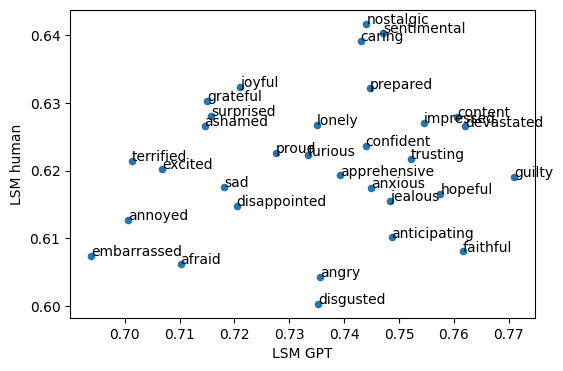

In [34]:
import matplotlib.pyplot as plt


gpt_byconv['LSM'] = gpt_lsm_array
human_byconv['LSM'] = human_lsm_array

lsm_by_context = (pd.merge(gpt_byconv.groupby("context")["LSM"].mean(),
                          human_byconv.groupby("context")["LSM"].mean(), 
                          left_index=True,
                          right_index=True)
                    .rename(columns={"LSM_x": "LSM GPT", "LSM_y": "LSM human"})
)

ax = lsm_by_context.plot.scatter(x='LSM GPT', y='LSM human', figsize=(6,4))

# Ajout des labels
for i, txt in enumerate(lsm_by_context.index):
    ax.annotate(txt, (lsm_by_context['LSM GPT'].iloc[i], lsm_by_context['LSM human'].iloc[i]))


<font color="red">3.3 Question:</font> What are scenarios selected for this project? Why? 

<font color="orange">3.3 Answer:</font> 

# <font color="green">**4 - Modeling for ChatGPT-Generated Dialogue Detection**</font>

Our first baseline model can be defined since two corpora provide naturally labeled conversations.  

<font color="red">4.1 Question:</font> Which word embedding model is used by the paper? Why? Which word embedding model will you use? 

You can test several word embedding model and choos the one give you the best performance GPT generated dialogue classification.

<font color="orange">4.1 Answer:</font> 

In [36]:
from sentence_transformers import SentenceTransformer
import pickle

tot_byconv = pd.concat([human_byconv, gpt_byconv], join="inner", keys=[0, 1])

model = SentenceTransformer('all-MiniLM-L6-v2') # ou "all-mpnet-base-v2" ou 'intfloat/e5-large-v2'
embeddings_mini = model.encode(tot_byconv["conversation"].to_list(), normalize_embeddings=True, show_progress_bar=True)

# Sauvegarde
with open("embeddings_mini.pkl", "wb") as f:
    pickle.dump(embeddings_mini, f)
#    embeddings_mini = pickle.load(f)


/Users/andrew/MS_IA/NLP/human-gpt-linguistic-differences/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 1221/1221 [01:43<00:00, 11.84it/s]


<font color="red">4.2 Question:</font> How to define the binary classification task? Test both linear and non-linear models to see which model provide better performance? You can follow the test, train, valid seperation defined inside Empatheticdiaogues corpus.

<font color="orange">4.2 Answer:</font> 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline

embeddings_mini_lsm = np.column_stack((embeddings_mini, tot_byconv["LSM"].values))

X_train, X_test, y_train, y_test = train_test_split(embeddings_mini_lsm, tot_byconv.index.get_level_values(0), random_state=0)
pipe = Pipeline([('logistic', LogisticRegression())])
lr = LinearRegression()
print("Score avec LSM seul : ", pipe.fit(X_train[:, -1].reshape(-1, 1), y_train).score(X_test[:, -1].reshape(-1, 1), y_test))
print("Score sans LSM : ", pipe.fit(X_train[:, : -1], y_train).score(X_test[:, : -1], y_test))
print("Score avec LSM : ", pipe.fit(X_train, y_train).score(X_test, y_test))
print("Part du LSM expliquée par les embeddings : ", lr.fit(X_train[:, : -1], X_train[:,-1]).score(X_test[:, : -1], X_test[:,-1]))





Score avec LSM seul :  0.6753020684005734
Score sans LSM :  0.971329100962523
Score avec LSM :  0.9720458734384599
Part du LSM expliqué par les embeddings :  0.23501610333154765


<font color="red">4.3 Question:</font> What metrics do you use to evaluate your model's performance? What is the performance of your baseline model? In which scenario does your model achieve the best performance?Present the performance using appropriate graphs and visualizations where possible. 

<font color="orange">4.3 Answer:</font> 

In [ ]:
# To-do


# <font color="green">5 - Add Selected Features to Your Baseline Model</font>

Add calculated features into your baseline model. What is the performance if we use only the linguistic feature for our classification task? How to encode the features and add them to the existing word embedding?

<font color="red">5.1 Question:</font> Let's build a linear classifier using only the linguistic feature LSM. What are your best performance?  

List the tested linear classifier and their performance. Highlight the scenario that give best performance for each of them.

<font color="orange">5.1 Answer:</font> 

In [ ]:
#-------------------------------------------------#
#CODE POUR EXTRAIRE LES EMOTIONS DE GPT AVEC ELFEN 
#-------------------------------------------------#
import polars as pl
from elfen.extractor import Extractor
import os
import multiprocessing

# --- Multithreading CPU ---
nb_cores = multiprocessing.cpu_count()     # détecte le nombre total de cœurs
n_used = min(nb_cores, 8)                  # limite à 8 pour stabilité macOS ARM
for var in ["OMP_NUM_THREADS", "OPENBLAS_NUM_THREADS", "MKL_NUM_THREADS", "VECLIB_MAXIMUM_THREADS"]:
    os.environ[var] = str(n_used)
print(f"ELFEN utilisera {n_used}/{nb_cores} cœurs logiques disponibles.")
# Convertir en Polars
tot_byconv_pl = pl.from_pandas(tot_byconv.rename(columns={"conversation": "text"}))
# création de l'extracteur 
extracteur = Extractor(
    data=tot_byconv_pl,
    text_col="text",
    lang="en"              # langue anglaise
     #modèle qui sera utilisé : ici Spacy
)
#extraction du groupe "emotion"
extracteur.extract_feature_group("emotion")


ELFEN utilisera 8/10 cœurs logiques disponibles.
Extracting sentiment_score...
Extracting sentiment_score...
Extracting n_positive_sentiment...
Extracting n_positive_sentiment...
Extracting n_negative_sentiment...
Extracting n_negative_sentiment...
Extracting avg_valence...
Extracting avg_valence...
Extracting avg_arousal...
Extracting avg_arousal...
Extracting avg_dominance...
Extracting avg_dominance...
Extracting n_low_valence...
Extracting n_low_valence...
Extracting n_high_valence...
Extracting n_high_valence...
Extracting n_low_arousal...
Extracting n_low_arousal...
Extracting n_high_arousal...
Extracting n_high_arousal...
Extracting n_low_dominance...
Extracting n_low_dominance...
Extracting n_high_dominance...
Extracting n_high_dominance...
Extracting avg_emotion_intensity...
Extracting avg_emotion_intensity...
Extracting n_low_intensity...
Extracting n_low_intensity...
Extracting n_high_intensity...
Extracting n_high_intensity...


In [ ]:
# Récupérer les colonnes ajoutées directement dans ext.data
extraction = extracteur.data.drop(["nlp", "lemmas"]).to_pandas()
extraction["conv_id"] = tot_byconv.index.get_level_values(1)
extraction["source"] = tot_byconv.index.get_level_values(0)

# Standardisation sur 1 des variables de comptages
cols_to_divide = extraction.filter(regex="^n_").columns.drop("n_tokens")
extraction[cols_to_divide] = extraction[cols_to_divide].div(extraction["n_tokens"], axis=0)

extraction.to_csv("../data/GPT_valence_scores.csv")

In [103]:
from sklearn.metrics import roc_auc_score

# On constitue un X_train et un X_test stratifiés par contexte, en s'assurant que les conv_id identiques ne soient pas séparés
conv_df = extraction.drop_duplicates(subset="conv_id")[['conv_id', 'context']]
train_conv, test_conv = train_test_split(
    conv_df,
    test_size=0.2,
    stratify=conv_df['context'],
    random_state=42
)
X_train = extraction[extraction['conv_id'].isin(train_conv['conv_id'])].dropna(subset=["avg_valence"])
X_test  = extraction[extraction['conv_id'].isin(test_conv['conv_id'])].dropna(subset=["avg_valence"])

logistic = LogisticRegression()
emotion_features = ['LSM', 'n_positive_sentiment',
       'n_negative_sentiment', #'n_tokens',
         'sentiment_score', 'avg_valence',
       'avg_arousal', 'avg_dominance', 'n_low_valence', 'n_high_valence',
       'n_low_arousal', 'n_high_arousal', 'n_low_dominance',
       'n_high_dominance', 'n_low_intensity_anger',
       'n_low_intensity_anticipation', 'n_low_intensity_disgust',
       'n_low_intensity_fear', 'n_low_intensity_joy',
       'n_low_intensity_sadness', 'n_low_intensity_surprise',
       'n_low_intensity_trust', 'n_high_intensity_anger',
       'n_high_intensity_anticipation', 'n_high_intensity_disgust',
       'n_high_intensity_fear', 'n_high_intensity_joy',
       'n_high_intensity_sadness', 'n_high_intensity_surprise',
       'n_high_intensity_trust']

scores_roc = {}

for i, feature in enumerate(emotion_features):
    lrf = logistic.fit(X_train[[feature]], X_train["source"])
    y_proba = lrf.predict_proba(X_test[[feature]])[:, 1]
    scores_roc.update({feature: roc_auc_score(X_test["source"], y_proba)})

In [104]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(
        Cs=50,            
        cv=5,                 
        penalty='l1',
        solver='liblinear',    
        scoring='roc_auc',
        max_iter=5000,
        n_jobs=-1         # pour la parallélisation
    )
)

pipe.fit(X_train[emotion_features], X_train["source"])

print("Meilleur C :", logregcv.C_[0])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Meilleur C : 0.2682695795279725


In [105]:
logregcv = pipe.named_steps['logisticregressioncv']
coefs = pd.Series(logregcv.coef_[0], index=emotion_features)


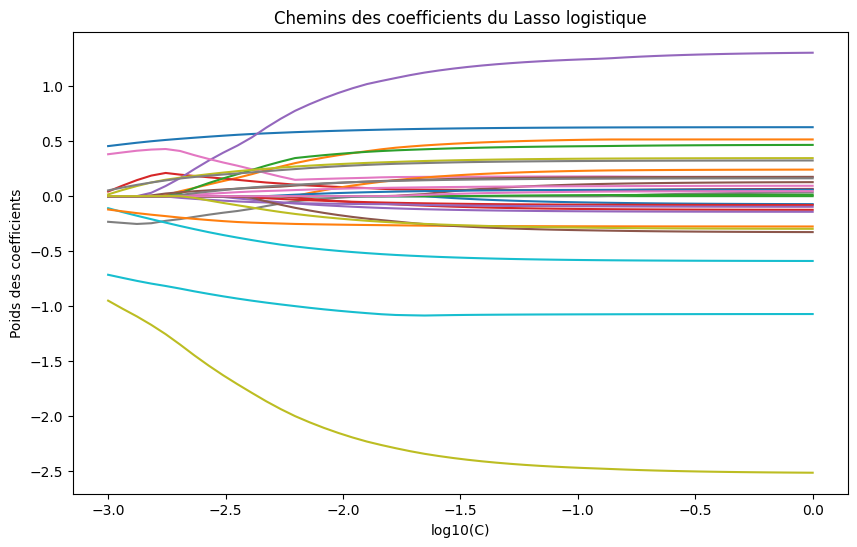

In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[emotion_features])

Cs = np.logspace(-3, 0, 50)
coefs_by_C = []

for C in Cs:
    lr = LogisticRegression(penalty="l1", solver="saga", C=C, max_iter=5000)
    lr.fit(X_train_scaled, X_train["source"])
    coefs_by_C.append(lr.coef_[0])

coefs_by_C = np.array(coefs_by_C)

plt.figure(figsize=(10,6))
plt.plot(np.log10(Cs), coefs_by_C)
plt.xlabel("log10(C)")
plt.ylabel("Poids des coefficients")
plt.title("Chemins des coefficients du Lasso logistique")
plt.show()

<font color="red">5.2 Question:</font> Try adding LSM to your baseline model. What is the nature of the calculated features (scaled, categorical, etc.)? How do you add them to the existing word embedding vector?

<font color="orange">5.2 Answer:</font> 

In [ ]:
# To-do

<font color="red">5.3 Question:</font> After adding LSM to your baseline model, are there any changes in the model's performance? How do you interpret the result? 

<font color="orange">5.3 Answer:</font> 

In [ ]:
# To-do

# <font color="green">**6 - Highlight Your Findings**</font>
This is an open question. Anything that stands out in your analysis should be highlighted. It could be a significant trend, an anomaly, or a correlation that was unexpected. Use visual aids like graphs or charts to make these findings clear and impactful.